<a id='1'></a>
## _Import Libraries and Load Data_

In [1]:
#general packages for data manipulation
import os
import pandas as pd
import numpy as np
#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent sized plot 
#handle the warnings in the code
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#text preprocessing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re

#display pandas dataframe columns 
pd.options.display.max_columns = None

#import the models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [2]:
#load the csv file as a pandas dataframe
#ISO-8859-1
tweet = pd.read_csv('/kaggle/input/twitter-hate-speech/TwitterHate.csv',delimiter=',',engine='python',encoding='utf-8-sig')
tweet.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
from pandas_profiling import ProfileReport

profile = ProfileReport(tweet, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
#get rid of the identifier number of the tweet
# Drop ID feature from data
tweet.drop('id',axis=1,inplace=True)

<AxesSubplot:xlabel='label', ylabel='count'>

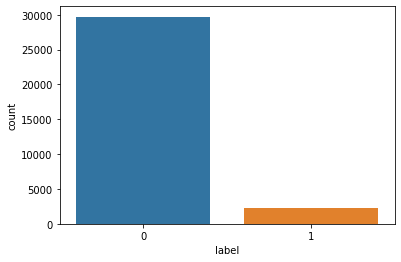

In [5]:
sns.countplot('label',data=tweet)

In [6]:
#create a copy of the original data to work with 
df = tweet.copy()

<a id='2'></a>
## _Text Cleaning_
## _Data Preprocessing_

<a name='2-1'></a>
### _Handle Diacritics using text normalization_

In [7]:
# Create a simplify function to handle diacrtics (ex:, ', ~, " etc.) from the data
def simplify(text):
    '''Function to handle the diacritics in the text'''
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [8]:
# Apply simplify function on the data
df['tweet'] = df['tweet'].apply(simplify)

<a id='2-2'></a>
### _Remove user handles_

In [9]:
#remove all the user handles --> strings starting with @ (ex: @user1, @user2, etc.)
df['tweet'].replace(r'@\w+','',regex=True,inplace=True)

<a id='2-3'></a>
### _Remove the urls_

In [10]:
# Remove urls from the data set
df['tweet'].replace(r'http\S+','',regex=True,inplace=True)

<a id='2-4'></a>
### _Tokenize using tweet tokenizer_

In [11]:
#tokenize the tweets in the dataframe using TweetTokenizer
# tokenizer breaks down sentences into each word (breaks them by leveraging spaces in sentences)
tokenizer = TweetTokenizer(preserve_case=True)
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [12]:
#Review the tokenized tweets
df.head(5)

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, can't, use, ca..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, u, take, with, u, all, the, ..."
4,0,"[factsguide, :, society, now, #motivation]"


<a id='2-5'></a>
### _Remove Stopwords_
_Append more words to be removed from the text - example rt and amp which occur very frequently_

In [13]:
# General stop words are a, an, the, he, she, is, in, be, by etc.)
stop_words = stopwords.words('english')

#add additional stop words to be removed from the text
add_list = ['amp','rt','u',"can't",'ur']

for words in add_list:
    stop_words.append(words)

In [14]:
# Checking the last 10 stop words among all stop words
stop_words[-10:]

["weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'amp',
 'rt',
 'u',
 "can't",
 'ur']

In [15]:
#define function to remove stop words from data set
def remove_stopwords(text):
    '''Function to remove the stop words from the text corpus'''
    clean_text = [word for word in text if not word in stop_words]
    return clean_text    

In [16]:
#remove the stop words from the tweets
df['tweet'] = df['tweet'].apply(remove_stopwords)

In [17]:
df['tweet'].head()

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, use, cause, offer, whe...
2                                    [bihday, majesty]
3                  [#model, love, take, time, !, !, !]
4                [factsguide, :, society, #motivation]
Name: tweet, dtype: object

<a id='2-6'></a>
### _Spelling corrections_

In [18]:
#apply spelling correction on a sample text
from textblob import TextBlob
sample = 'amazng man you did it finallyy'
txtblob = TextBlob(sample)
corrected_text = txtblob.correct()
print(corrected_text)

amazing man you did it finally


In [19]:
#apply auto correct on the twitter data set
#textblob expect a string to be passed and not a list of strings
from textblob import TextBlob

def spell_check(text):
    '''Function to do spelling correction using '''
    txtblob = TextBlob(text)
    corrected_text = txtblob.correct()
    return corrected_text
    

<a id='2-7'></a>
### _Remove # symbols while retaining the text_

In [20]:
#Defining function to remove hash symbols from data set
def remove_hashsymbols(text):
    '''Function to remove the hashtag symbol from the text'''
    pattern = re.compile(r'#')
    text = ' '.join(text)
    clean_text = re.sub(pattern,'',text)
    return tokenizer.tokenize(clean_text)    

In [21]:
df['tweet'] = df['tweet'].apply(remove_hashsymbols)

<a id='2-8'></a>
### _Remove single and double length characters_

In [22]:
# Define function to remove words containing only 1 or 2 chacters like 'a', 'ig' etc.
def rem_shortwords(text):
    '''Function to remove the short words of length 1 and 2 characters'''
    '''Arguments: 
       text: string
       returns: string without containing words of length 1 and 2'''
    lengths = [1,2]
    new_text = ' '.join(text)
    for word in text:
        text = [word for word in tokenizer.tokenize(new_text) if not len(word) in lengths]
        
    return new_text       
    

In [23]:
# Remove the short words
df['tweet'] = df['tweet'].apply(rem_shortwords)

In [24]:
# Again apply tokenizer to break the sentences into words
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

<a id='2-9'></a>
### _Remove digits_

In [25]:
# Defining a function to remove digits from the dataset
def rem_digits(text):
    '''Function to remove the digits from the list of strings'''
    no_digits = []
    for word in text:
        no_digits.append(re.sub(r'\d','',word))
    return ' '.join(no_digits)   

In [26]:
df['tweet'] = df['tweet'].apply(rem_digits)

In [27]:
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

<a id='2-10'></a>
### _Remove special characters_


In [28]:
# Defining a function to remove special charcters from the dataset
def rem_nonalpha(text):
    '''Function to remove the non-alphanumeric characters from the text'''
    text = [word for word in text if word.isalpha()]
    return text

In [29]:
#remove the non alpha numeric characters from the tweet tokens
df['tweet'] = df['tweet'].apply(rem_nonalpha)

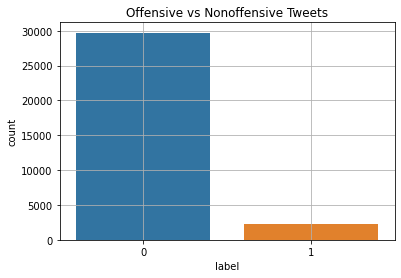

In [30]:
# Data Visualization for hate and non hate tweets
sns.countplot(df['label'])
plt.title('Offensive vs Nonoffensive Tweets')
plt.grid()
plt.show()

<a id='3-2'></a>
### _Check out the top terms in the tweets_

In [31]:
# Data visualization on the most used terms in tweets
from collections import Counter
results = Counter()
df['tweet'].apply(results.update)
#print the top 10 most common terms in the tweet 
print(results.most_common(15))

[('love', 2762), ('day', 2319), ('happy', 1679), ('like', 1160), ('time', 1138), ('life', 1124), ('today', 1017), ('new', 994), ('thankful', 947), ('positive', 931), ('get', 919), ('good', 860), ('people', 858), ('bihday', 855), ('one', 784)]


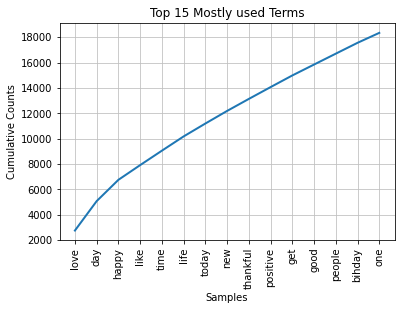

In [32]:
#plot the frequency of the 15 mostly used terms 
frequency = nltk.FreqDist(results)
plt.title('Top 15 Mostly used Terms')
frequency.plot(15,cumulative=True)
plt.show()

_Love is the most frequently used word followed by day, happy etc. This is expected as there are more non hate tweets than hate tweets in the dataset_

<a id='4'></a>
## _Predictive Modeling_

### _Data Formatting for Predictive Modeling_

In [33]:
# A final check on the dataset before applying the ML models
df.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,0,"[thanks, lyft, credit, use, cause, offer, whee..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time]"
4,0,"[factsguide, society, motivation]"


In [34]:
#Add tokens to make the preprocessed tweets
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))

In [35]:
#split the data into input X and output y
X = df['tweet']
y = df['label']

In [36]:
#split the dataset into train and test data
test_size = 0.25 #splitting the train and test data in 75%:25% ratio 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=23,stratify=df['label'])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(23971,) (7991,) (23971,) (7991,)


<a id='4-2'></a>
### _Use tf-idf as a feature to get into the vector space model_


In [37]:
#import tfidf vectorizer
#To convert texts to a matrix of TF-IDF features. 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [38]:
# Defining the maximum number of features by term frequency to be considered for ML Models 
vectorizer = TfidfVectorizer(max_features=4500)

In [39]:
#fitting the tdif vectorizer on the training dataset
X_train = vectorizer.fit_transform(X_train)
#transform the test data and apply the tdif vectorizer
X_test = vectorizer.transform(X_test)

In [40]:
#check the shape
X_train.shape, X_test.shape

((23971, 4500), (7991, 4500))

In [41]:
from sklearn.model_selection import StratifiedKFold
#define the number of folds 
seed = 51
folds = StratifiedKFold(n_splits=4,shuffle=True, random_state=seed)

model_factory = [CatBoostClassifier(verbose=False), 
                 LGBMClassifier(objective='binary'),
                 RandomForestClassifier(n_jobs=-1),
                 XGBClassifier(objective='binary:logistic'),
                 DecisionTreeClassifier()] 
                
val = []
model_name = []

for model in model_factory:
    mf = model.fit(X_train, y_train)
    Pred = mf.predict(X_test)
    scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print(model.__class__.__name__, " : Train Accuracy: ", accuracy_score(y_test, Pred), " : Validation Accuracy : ", np.mean(scores))
    model_name.append(model.__class__.__name__)
    val.append(np.mean(scores).item())

In [42]:
model_factory = [LogisticRegression(), 
                 LGBMClassifier(objective='binary'),
                 RandomForestClassifier(n_jobs=-1),
                 MultinomialNB(),
                 DecisionTreeClassifier(),
                 SVC(C=100.0),
                 XGBClassifier(objective='binary:logistic')]  
                
val = []
model_name = []

for model in model_factory:
    mf = model.fit(X_train, y_train)
    Pred = mf.predict(X_test)
    scores=cross_val_score(model, X_train, y_train, cv=folds, scoring='accuracy')
    print(model.__class__.__name__, " : Train Accuracy: ", accuracy_score(y_test, Pred), " : Validation Accuracy : ", np.mean(scores))
    model_name.append(model.__class__.__name__)
    val.append(np.mean(scores).item())

LogisticRegression  : Train Accuracy:  0.9504442497810036  : Validation Accuracy :  0.9474781938518838
LGBMClassifier  : Train Accuracy:  0.9494431235139532  : Validation Accuracy :  0.9490217308488742
RandomForestClassifier  : Train Accuracy:  0.9582029783506445  : Validation Accuracy :  0.9587001479474161
MultinomialNB  : Train Accuracy:  0.9508196721311475  : Validation Accuracy :  0.9496474887145817
DecisionTreeClassifier  : Train Accuracy:  0.9450631960956075  : Validation Accuracy :  0.9426391036538623
SVC  : Train Accuracy:  0.9622074834188462  : Validation Accuracy :  0.9605356157060853
[14:11:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:11:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

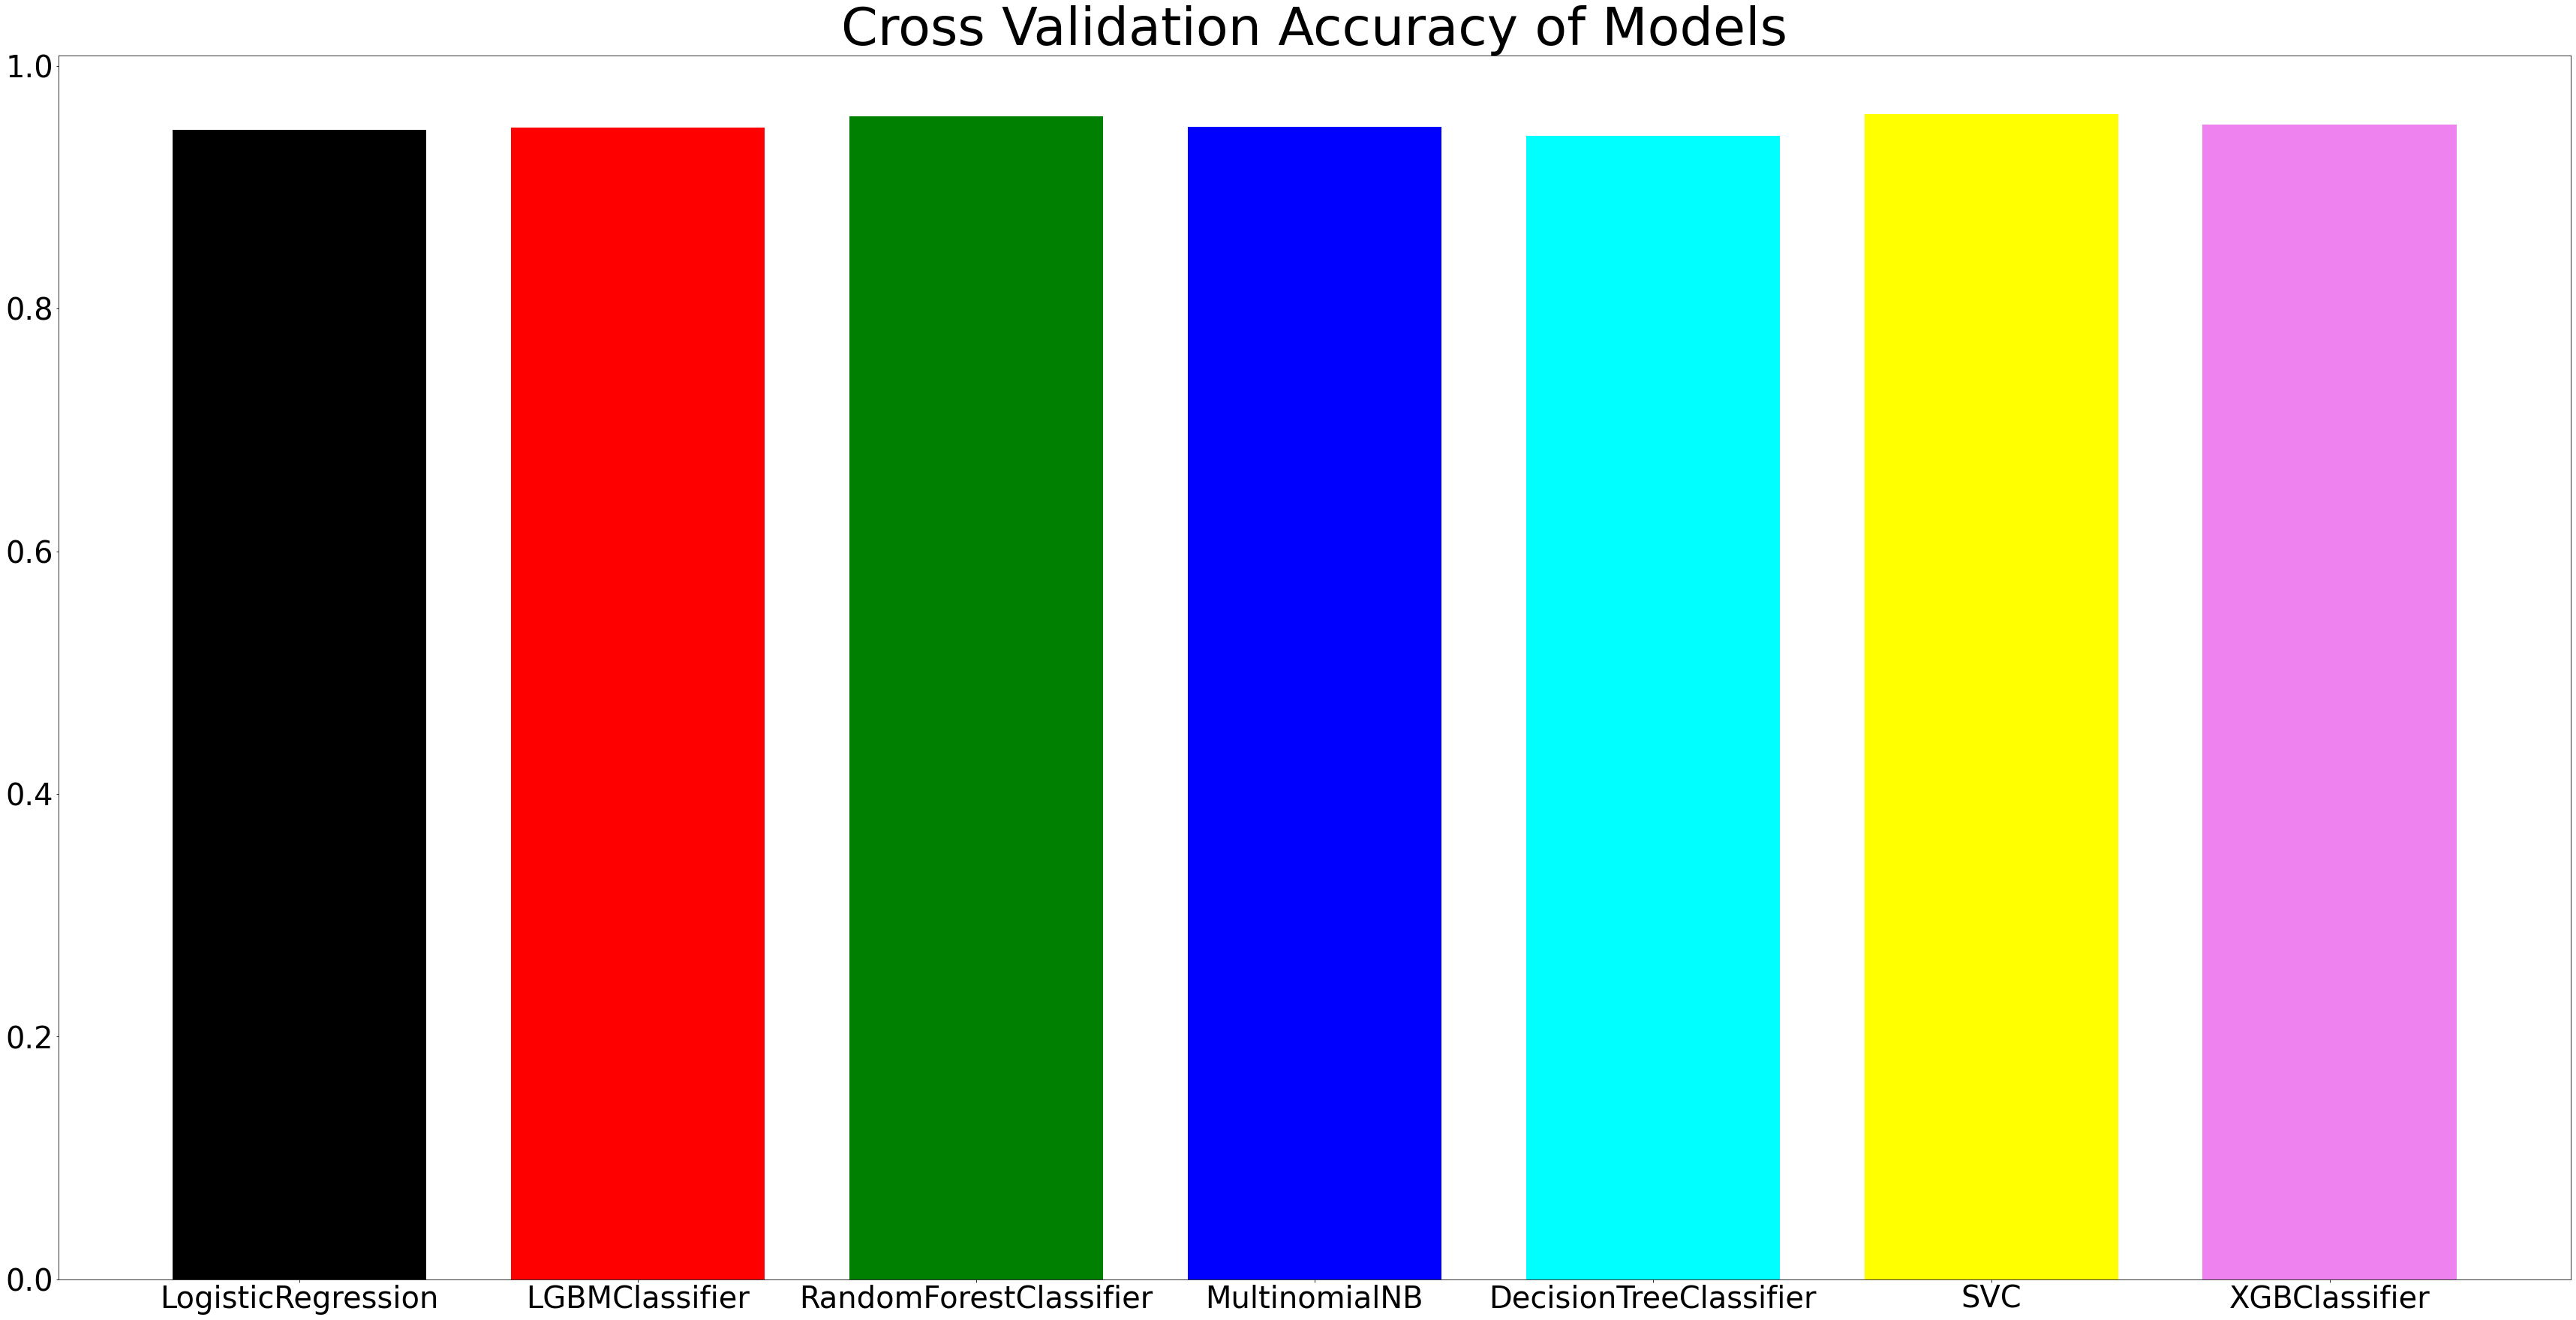

In [43]:
fig = plt.figure(figsize = (60,30))
plt.bar(model_name, val, color=['black', 'red', 'green', 'blue', 'cyan', 'yellow', 'violet'], width=0.75)
plt.title('Cross Validation Accuracy of Models',fontsize=70)
plt.tick_params(axis='both', which='major',labelsize=40)
plt.show()

In [44]:
# SVC is giving the highest cross validation accuracy of 0.9605356157060853
# Hence, tuning the SVC ML model

# Hyperparameter Optimization using GridSearch CV
# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100], 'kernel':['linear']},
               {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100], 'kernel':['poly'], 'degree': [2,3] ,'gamma':[0.01,0.02,0.03]} 
              ]

grid_search = GridSearchCV(estimator = SVC(),  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = folds,
                           verbose=0)


grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=51, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'degree': [2, 3],
                          'gamma': [0.01, 0.02, 0.03], 'kernel': ['poly']}],
             scoring='accuracy')

In [45]:
# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.9612


Parameters that give the best results : 

 {'C': 100, 'gamma': 0.8, 'kernel': 'rbf'}


Estimator that was chosen by the search : 

 SVC(C=100, gamma=0.8)


In [46]:
# calculate GridSearch CV score on test set

print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV score on test set: 0.9622
